# Flow Matching

TL;DR: This write-up contains the minimum essential concepts and simple code to understand flow matching.

If you have any questions or notice any errors, please contact [Wenhan Gao](https://wenhangao21.github.io/).

## Import Dependencies

In [33]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import copy
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print("Using device:", device)

Using device: cpu


## Problem Formulation

**Given samples from two distributions $\pi_0$ and $\pi_1$, we aim to find a transport map $\mathcal{T}$ such that, when $X_0 \sim \pi_0$, then $X_1 = \mathcal{T}(Z_0) \sim \pi_1$.**
- $\pi_0$ is the source distribution, and $\pi_1$ is the target distribution.
- For image generation, $\pi_1$ can be the image data distribution and $\pi_0$ can be any prior distribution easy to sample from, e.g. Gaussian.


**Code:** We will use the standard Gaussian distribution as the source distribution and the “checkerboard distribution” as the target distribution. Let’s set up these two distributions.

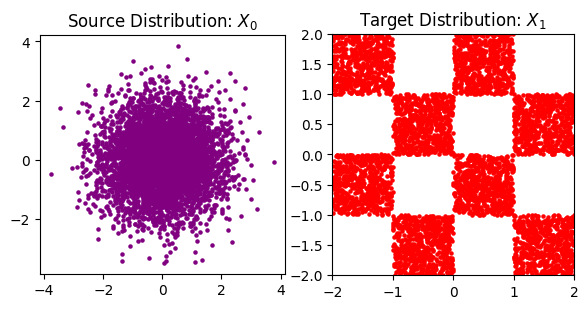

In [108]:
def sample_checkerboard(N=1000, grid_size=4, scale=2.0):
    """
    Generate samples from a 2D checkerboard distribution.
    This function divides the square domain [-scale, scale] × [-scale, scale]
    into a grid of `grid_size × grid_size` equally sized square cells.
    """
    grid_length = 2 * scale / grid_size
    # Randomly choose integer tile coordinates
    gx = np.random.randint(0, grid_size, size=N)
    gy = np.random.randint(0, grid_size, size=N)
    mask = ((gx % 2) ^ (gy % 2)).astype(bool) # Keep only tiles where (even, odd) or (odd, even) — XOR rule
    while not np.all(mask): # Resample indices until all entries satisfy the checkerboard mask
        bad = np.where(~mask)[0]
        gx[bad] = np.random.randint(0, grid_size, size=len(bad))
        gy[bad] = np.random.randint(0, grid_size, size=len(bad))
        mask = ((gx % 2) ^ (gy % 2)).astype(bool)
    # Sample uniformly inside each chosen tile
    offsets = np.random.rand(N, 2) * grid_length
    xs = -scale + gx * grid_length + offsets[:, 0]
    ys = -scale + gy * grid_length + offsets[:, 1]
    return np.stack([xs, ys], axis=1).astype(np.float32)

def sample_pi_0(N=1000):
  return np.random.randn(N, 2).astype(np.float32)

def sample_pi_1(N=1000, grid_size=4, scale=2.0):
  return sample_checkerboard(N=N, grid_size=grid_size, scale=scale)

# Generate data
pi_0 = sample_pi_0(N=5_000)
grid_size, scale = 4, 2
pi_1 = sample_pi_1(N=5_000, grid_size=grid_size, scale=scale)
# Plot
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].scatter(pi_0[:, 0], pi_0[:, 1], c='purple', s=5)
axes[0].set_aspect('equal', 'box')
axes[0].set_title("Source Distribution: $X_0$")
axes[1].scatter(pi_1[:, 0], pi_1[:, 1], c='red', s=5)
axes[1].set_xlim(-scale, scale)
axes[1].set_ylim(-scale, scale)
axes[1].set_aspect('equal', 'box')
axes[1].set_title("Target Distribution: $X_1$")

plt.tight_layout()
plt.show()

## Transport Map: ODEs

In flow models, the mapping $\mathcal{T}$ is implicitly defined by an ordinary differential equation (ODE):

$$
\frac{d}{d t} X_t=v\left(X_t, t\right), \quad X_0 \sim \pi_0, \quad \forall t \in[0,1],
$$
where $v\left(X_t, t\right)$ is called the velocity field. Given the source data $X_0 \sim \pi_0$, we can generate the target data $X_1 \sim \pi_1$ by following the ODE.


## Interpolants

There are infinitely many ways to define the vector field $v$:

<figure id="figure-1" style="margin: 0 auto 1em auto;">
  <div style="display: flex; justify-content: center;">
    <img src="https://mlg.eng.cam.ac.uk/blog/assets/images/flow-matching/forward_samples-one-color-3.png" width="400"> <img src="https://mlg.eng.cam.ac.uk/blog/assets/images/flow-matching/forward_samples_ot-one-color.png" width="400">
  </div>
  <figcaption>
    <a href="#figure-1">Figure 1</a>.
    Two different velocity fields that lead to the same endpoint distributions. Image from <a href="https://mlg.eng.cam.ac.uk/blog/2024/01/20/flow-matching.html">Tor Fjelde et al., 2024</a>.
  </figcaption>
</figure>

To define a specific $v$, we leverage an interpolation process with some time schedule $\alpha_t, \beta_t$:
$$X_t=\alpha_t X_0+\beta_t X_1,$$
where $t \in[0,1], \alpha_0=\beta_1=1$, $\alpha_1=\beta_0=0$, and $\{X_t\}_t$ are the trajectories. A common interpolant is the linear interpolant: $\alpha_t=1-t$ and $\beta_t=t$.




## Conditional Velocity

Differentiate both sides with respect to $t$ gives us an "ODE":
$$
\frac{d X_t}{d t}=\alpha_t^{\prime} X_0+\beta_t^{\prime} X_1 \triangleq  v_s\left(X_t, t \mid X_0, X_1 \right),
$$
where $v_s$ is the conditional velocity of a sample trajectory conditioned on the endpoints $X_0$ and $X_1$. **This ODE is not generative because the endpoints must be given.**




## Learning the Velocity

To resolve the non-generative issue, we learn a velocity field $v_\theta\left(X_t, t\right)$ such that the generative ODE $\frac{d}{d t} X_t=v_\theta\left(X_t, t\right)$ can approximate the previous non-generative process as closely as possible.

The simplest way to do this is to minimize the squared error between the two systems' velocity fields:
$$
\min _\theta \int_0^1 \mathbb{E}_{X_0 \sim \pi_0, X_1 \sim \pi_1}\left[\left\|\left(\alpha_t^{\prime} X_0+\beta_t^{\prime} X_1\right)-v_\theta\left(X_t, t\right)\right\|^2\right] d t,
$$
and it is equivalent to
$$
\min _\theta \mathbb{E}_{X_0 \sim \pi_0, X_1 \sim \pi_1, t\sim \text{Uniform}(0,1)}\left[\left\|\left(\alpha_t^{\prime} X_0+\beta_t^{\prime} X_1\right)-v_\theta\left(X_t, t\right)\right\|^2\right].
$$

**Code**: We will use the linear interpolant $\alpha_t=1-t$ and $\beta_t=t$ with $\alpha_t^{\prime} X_0+\beta_t^{\prime} X_1 = X1 - X0$.


1. We setup the velocity network $v_\theta$.

In [35]:
class MLP_FM(nn.Module):
    def __init__(self, in_dim=2, context_dim=1, h=128, out_dim=2): # context is time
        super(MLP_FM, self).__init__()
        self.context_dim = context_dim
        self.network = nn.Sequential(nn.Linear(in_dim + context_dim, h), nn.GELU(),
                                     nn.Linear(h, h), nn.GELU(),
                                     nn.Linear(h, h), nn.GELU(),
                                     nn.Linear(h, h), nn.GELU(),
                                     nn.Linear(h, out_dim))

    def forward(self, x, t):
        return self.network(torch.cat((x, t), dim=1))

2. We train the velocity network by randomly sampling $X_0, X_1$, and $t$, and minimizing the squared error above.

In [36]:
def train_flow_matching(flow_model, n_iterations=5_001, lr=3e-3, batch_size=4096, save_freq=2_000):
    optimizer = torch.optim.Adam(flow_model.parameters(), lr=lr)
    losses = []
    checkpoints = []
    progress_bar = tqdm(range(n_iterations), desc="Training Flow Matching", ncols=100)
    for iteration in progress_bar:
        x1 = torch.from_numpy(sample_pi_1(N=batch_size)).to(device)
        x0 = torch.from_numpy(sample_pi_0(N=batch_size)).to(device)
        t = torch.rand((x1.shape[0], 1), device=device) # randomly sample t
        x_t = t * x1 + (1.-t) * x0  # swap x0, x1 in the equations above
        v = x1 - x0  # swap x0, x1 in the equations above
        v_pred = flow_model(x_t, t)
        loss = torch.nn.functional.mse_loss(v_pred, v)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
        progress_bar.set_postfix({"loss": f"{loss.item():.6f}"})
        if iteration % save_freq == 0:
          checkpoints.append({
              'iteration': iteration,
              'model_state_dict': copy.deepcopy(flow_model.state_dict()),
              'optimizer_state_dict': copy.deepcopy(optimizer.state_dict()),
              'loss': loss.item(),
          })
    if iteration % save_freq != 0:
      checkpoints.append({
          'iteration': iteration,
          'model_state_dict': copy.deepcopy(flow_model.state_dict()),
          'optimizer_state_dict': copy.deepcopy(optimizer.state_dict()),
          'loss': loss.item(),
      })
    return flow_model, losses, checkpoints

In [27]:
flow_model = MLP_FM(in_dim=2, context_dim=1, h=128, out_dim=2).to(device)
trained_model_FM, training_losses_FM, checkpoints_FM = train_flow_matching(flow_model=flow_model)

Training Flow Matching: 100%|████████████████████| 5001/5001 [04:39<00:00, 17.91it/s, loss=1.658475]


## Sampling

Once the velocity field $v_\theta\left(X_t, t\right)$ is learned, we can simulate samples from $\pi_1$ given samples from $\pi_0$ by solving the ODE:$
\frac{d}{d t} X_t=v_\theta\left(X_t, t\right),~X_0 \sim \pi_0,~t \in[0,1]$. One way to solve it is using the [forward Euler method](https://en.wikipedia.org/wiki/Euler_method):

$$X_{t+\Delta t}=X_t+\Delta t \cdot v_\theta\left(X_t, t\right),$$
where $\Delta t = \frac{1}{T}$ with T being the number of steps used in sampling.

In [37]:
def sample_mean_flow(flow_model, N, T):
    """
    Generate N samples from pi_1 with the mean flow model in T timesteps.
    """
    x = torch.from_numpy(sample_pi_0(N=N)).to(device)
    dt = 1./T
    for i in (range(T)):
        t = torch.ones((x.shape[0], 1), device=x.device) * (i * dt)
        v_pred = flow_model(x.squeeze(0), t)
        x = x + v_pred * 1. / T # reverse integration as we learn the velocity from data to noise
    return x

def visualize_mean_flow_sampling(flow_model, N, T):
    """
    Visualize N generated samples with T timesteps.
    """
    sampled_pi_1 = sample_mean_flow(flow_model, N=N, T=T).detach().cpu().numpy()
    plt.figure(figsize=(3,3))
    plt.scatter(pi_1[:, 0], pi_1[:, 1], s=5, alpha=0.05,
                color='gray', label='Target')
    plt.scatter(sampled_pi_1[:, 0], sampled_pi_1[:, 1], s=5, alpha=0.3,
                color='red', label='Denoised')
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.gca().set_aspect('equal')
    plt.title(f"Denoising Steps = {T}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

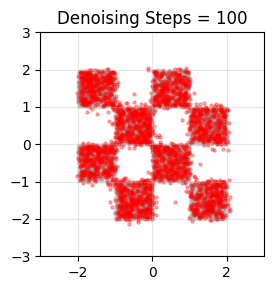

In [39]:
visualize_mean_flow_sampling(trained_model_FM, N=3000, T=100)

## Additional Visualization

### Evolution: $\pi_0$ to $\pi_1$

In [68]:
def sample_mean_flow_xt(flow_model, N, T, num_xt):
    """
    Generate N samples from pi_1 with the mean flow model in T timesteps.
    Also save the sample X_t for intermidiate time between 0 and 1.
    """
    record_times = torch.linspace(0.0, 1.0, steps=num_xt).tolist()
    record_times = sorted(record_times)
    dt = 1.0 / T
    target_indices = {rt: int(round((rt) / dt)) for rt in record_times}
    xt = {}
    x = torch.from_numpy(sample_pi_0(N=N)).to(device)
    if 0 in target_indices:
        xt[0] = x.clone()
    for i in range(T):
        t = torch.ones((x.shape[0], 1), device=x.device) * (i * dt)
        v_pred = flow_model(x.squeeze(0), t)
        x = x + v_pred * 1. / T # reverse integration as we learn the velocity from data to noise
        for rt, idx in target_indices.items():
            if idx == i+1:
                xt[rt] = x.clone()
    return xt

In [111]:
def visualize_mean_flow_xt(flow_model, N, T, num_xt, max_cols=3):
    """
    Visualize samples at intermediate times from sample_mean_flow_xt
    using up to `max_cols` columns.
    """
    xt_dict = sample_mean_flow_xt(flow_model, N=N, T=T, num_xt=num_xt)
    times_sorted = sorted(xt_dict.keys())
    num_plots = len(times_sorted)
    # Determine layout
    cols = min(max_cols, num_plots)
    rows = int(np.ceil(num_plots / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
    axes = axes.flatten()  # Make axes indexable in 1D
    target = pi_1  # Shape [N, 2]

    for i, t in enumerate(times_sorted):
        ax = axes[i]
        x_t = xt_dict[t].detach().cpu().numpy()
        # Background: target distribution
        ax.scatter(target[:, 0], target[:, 1], s=5, alpha=0.05, color='gray')
        # Current X_t
        ax.scatter(x_t[:, 0], x_t[:, 1], s=5, alpha=0.4, color='red')
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        ax.set_title(f"t = {t:.2f}")
    # Hide unused axes
    for j in range(i+1, rows*cols):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

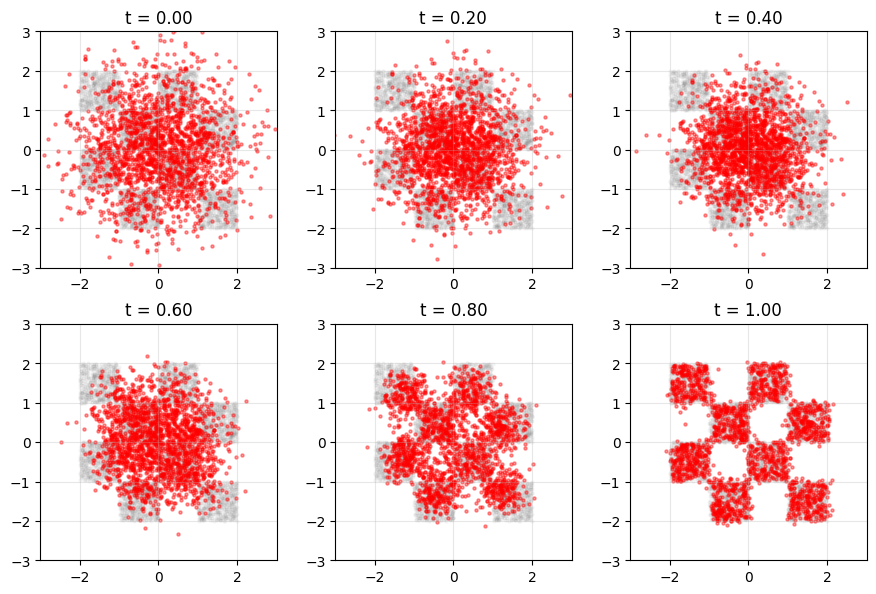

In [114]:
visualize_mean_flow_xt(flow_model, N=2000, T=100, num_xt=6)

### Flow Matching at Different Training Stages

In [119]:
def visualize_all_checkpoints(flow_model, checkpoints, N, T, mean_flow=False, max_cols=4):
    """
    Plot sampling from ALL checkpoints using up to `max_cols` columns.
    """
    num_plots = len(checkpoints)
    # Determine layout
    cols = min(max_cols, num_plots)
    rows = int(np.ceil(num_plots / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    axes = axes.flatten()  # Make indexing simpler
    for i, checkpoint in enumerate(checkpoints):
        ax = axes[i]
        iteration = checkpoint["iteration"]
        # Load model state
        flow_model.load_state_dict(checkpoint["model_state_dict"])
        # Sample using this checkpoint
        if mean_flow:
            sampled_pi_1 = sample_mean_flow(flow_model, N=N, T=T)
        else:
            sampled_pi_1 = sample_mean_flow(flow_model, N=N, T=T)
        sampled_pi_1 = sampled_pi_1.detach().cpu().numpy()
        # Plot target vs sampled
        ax.scatter(pi_1[:, 0], pi_1[:, 1], s=5, alpha=0.05, color='gray')
        ax.scatter(sampled_pi_1[:, 0], sampled_pi_1[:, 1], s=5, alpha=0.3, color='red')
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_aspect('equal')
        ax.set_title(f"Flow Matching — ite={iteration}")
        ax.grid(True, alpha=0.3)
    # Hide unused axes (if any)
    for j in range(i + 1, rows * cols):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

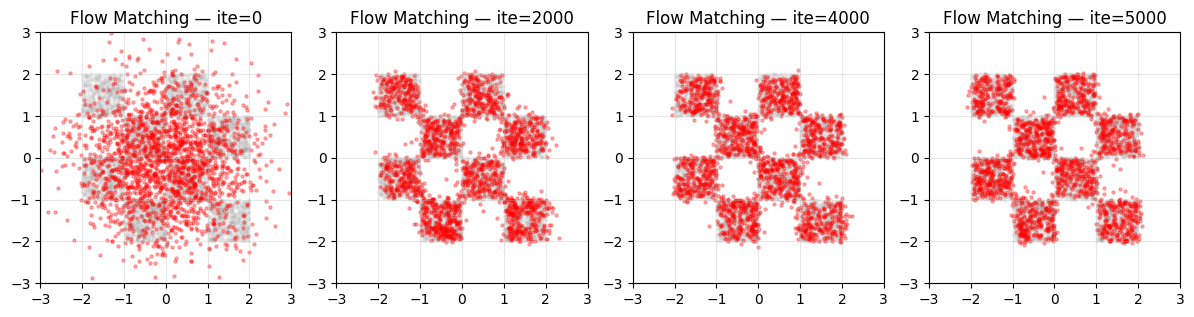

In [120]:
visualize_all_checkpoints(
    flow_model,
    checkpoints_FM,
    N=2000,
    T=100,
    mean_flow=False
)

## Marginal Velocity

Although the regression target for each sample is the conditional velocity $\alpha_t^{\prime} X_0+\beta_t^{\prime} X_1$. The **underlying unique regression target** is the marginal velocity $v\left(X_t, t\right)=\mathbb{E}_{X_0, X_1 \mid X_t, t}\left[\alpha_t^{\prime} X_0+\beta_t^{\prime} X_1\right]$. To see this:

$$\begin{aligned} \mathcal{L} & =\mathbb{E}_{X_0, X_1, t}\left[\left\|v_s\left(X_t, t \mid X_0, X_1 \right) - v_\theta(X_t, t)\right\|^2\right] \\ & =\mathbb{E}_{X_t, t}\left[\mathbb{E}_{X_0, X_1 \mid X_t, t}\left[\left\|\alpha_t^{\prime} X_0+\beta_t^{\prime} X_1 - v_\theta(X_t,t) \right\|^2\right]\right] .\end{aligned}$$

Since the expectation operator is linear, the optimal velocity field is:

$$
v^*\left(X_t, t\right)=\mathbb{E}_{X_0, X_1 \mid X_t, t}\left[\alpha_t^{\prime} X_0+\beta_t^{\prime} X_1\right].
$$

**Therefore, even if we use a linear interpolant with straight-line sample trajectories, the sampling cannot be done in one step, since the actual regression target is not the marginal velocity.**
